In [2]:
import sys
from datetime import datetime
from pathlib import Path
from joblib import Parallel, delayed
from typing import List, Dict, Any

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction

data_dir = Path("measurements")
state_dir = Path("state_vectors")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Saving results to: {results_dir}")

Running on: cpu
Saving results to: results


In [3]:
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000

SAMPLE_SIZES = [2_000, 5_000, 20_000]

H_TRAIN = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
H_EVAL  = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50]
ALL_H = sorted(list(set(H_TRAIN + H_EVAL)))

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in H_TRAIN]
file_paths = [data_dir / fn for fn in file_names]

print(f"Sample sizes to sweep: {SAMPLE_SIZES}")
print(f"Support points: {H_TRAIN}")

print("Pre-loading ground truth wavefunctions...")
all_states = generate_basis_states(SIDE_LENGTH**2, device)
gt_map: Dict[float, torch.Tensor] = {}

for h_val in ALL_H:
    gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"
    gt_map[h_val] = load_gt_wavefunction(gt_path, device)

print(f"Loaded {len(gt_map)} GT states.")

Sample sizes to sweep: [2000, 5000, 20000]
Support points: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Pre-loading ground truth wavefunctions...
Loaded 14 GT states.


In [4]:
N_EPOCHS = 50
BATCH_SIZE = 1024
NUM_HIDDEN = 64
HYPER_NET_WIDTH = 64
K_STEPS = 10
GIBBS_NOISE_FRAC = 0.1
INIT_LR = 1e-2
FINAL_LR = 1e-4
INIT_STD = 0.05

In [5]:
def train_and_evaluate_seed(seed: int) -> pd.DataFrame:
    print(f"Starting seed {seed}...")

    torch.manual_seed(seed)
    rng = torch.Generator(device=device).manual_seed(seed)

    seed_results = []

    for n_samples in SAMPLE_SIZES:

        dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [n_samples] * len(file_paths))
        loader = MeasurementLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, rng=rng)

        model = SymmetricHyperRBM(num_v=dataset.num_qubits, num_h=NUM_HIDDEN,
                                  hyper_dim=HYPER_NET_WIDTH, k=K_STEPS).to(device)
        model.initialize_weights(std=INIT_STD)

        optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
        scheduler = get_sigmoid_curve(INIT_LR, FINAL_LR, N_EPOCHS * len(loader), 0.005)

        model = train_loop(model, optimizer, loader, num_epochs=N_EPOCHS,
                           lr_schedule_fn=scheduler, noise_frac=GIBBS_NOISE_FRAC, rng=rng)

        for h in ALL_H:
            psi_true = gt_map[h]
            overlap = calculate_exact_overlap(model, h, psi_true, all_states)

            p_type = "support" if any(np.isclose(h, s) for s in H_TRAIN) else "novel"

            seed_results.append({"seed": seed, "n_samples": n_samples, "h": float(h),
                                 "type": p_type, "overlap": float(overlap)})

    df = pd.DataFrame(seed_results)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_sample_eff_rbm_seed{seed}_{ts}.csv"
    df.to_csv(results_dir / save_name, index=False, float_format="%.6e")

    print(f"Seed {seed} finished.")
    return df

In [6]:
SEEDS = list(range(42, 45))

results_list = Parallel(n_jobs=4)(delayed(train_and_evaluate_seed)(s) for s in SEEDS)

all_results_df = pd.concat(results_list, ignore_index=True)
print("\nTraining and evaluation complete for all seeds.")


Training and evaluation complete for all seeds.


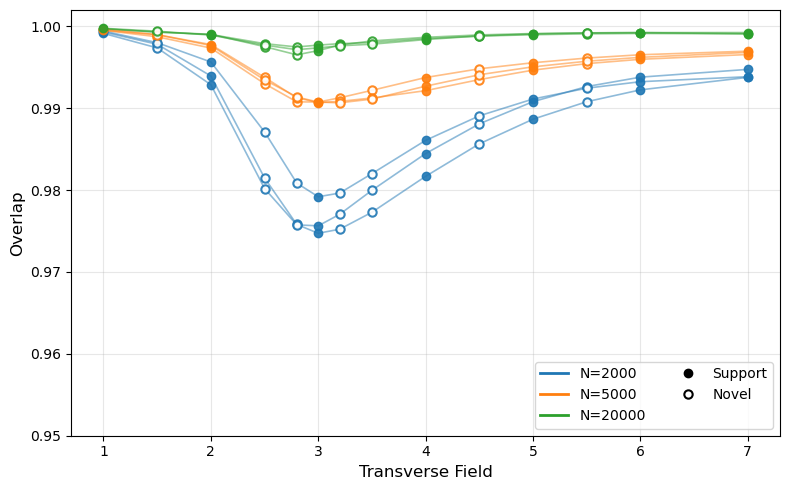

In [7]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

cmap = plt.get_cmap("tab10")
color_map = {n: cmap(i) for i, n in enumerate(SAMPLE_SIZES)}

LINE_KW = dict(lw=1.2, alpha=0.5, zorder=5)
MARKER_KW = dict(markersize=6, alpha=0.9, zorder=6)

for seed in SEEDS:
    seed_df = all_results_df.query("seed == @seed")

    for n_samples in SAMPLE_SIZES:
        df = seed_df.query("n_samples == @n_samples").sort_values("h")
        c = color_map[n_samples]

        ax.plot(df["h"], df["overlap"], "-", color=c, **LINE_KW)

        supp = df.query("type == 'support'")
        ax.plot(supp["h"], supp["overlap"], "o", color=c, **MARKER_KW)

        nov = df.query("type == 'novel'")
        ax.plot(nov["h"], nov["overlap"], "o", color=c,
                markerfacecolor="white", markeredgewidth=1.5, **MARKER_KW)

sample_handles = [Line2D([0], [0], color=color_map[n], lw=2, label=f"N={n}") for n in SAMPLE_SIZES]

marker_handles = [
    Line2D([0], [0], color="black", marker="o", linestyle="", label="Support"),
    Line2D([0], [0], color="black", marker="o", markerfacecolor="white",
           markeredgewidth=1.5, linestyle="", label="Novel"),
]

ax.legend(handles=sample_handles + marker_handles, loc="lower right", ncol=2)

ax.set_xlabel(r"Transverse Field", fontsize=12)
ax.set_ylabel(r"Overlap", fontsize=12)

ax.set_ylim(0.95, 1.002)
ax.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()